# XAI Laboratory 01 - Tabular Methods

For this practice, you will need the following dataset:

- **fifa**: regression dataset containing FIFA players data:
    - short_name: name of the player
    - nationality
    - overall: overall score of the player (potential output)
    - potential: potential score of the player (potential output)
    - wage_eur: contract cancellation fine of the player (potential output)
    - value_eur: value in euros of the player (potential output)
    - age: age of the player in years
    - height_cm: height of the player in cm
    - weight_kg: weight of the player in kg
    - attacking_skills: several variables related to attacking
    - defending_skills: several variables related to defending
    - goalkeeping_skills: several variables related to goalkeeping

Use what you have learned from the `tabular_explanation.ipynb` notebook to complete the questions.

In [2]:
# Data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Models
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV

# XAI
import shap
import lime
from alepython import ale_plot # You might need to install from source: pip install git+https://github.com/MaximeJumelle/ALEPython.git@dev#egg=alepython
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import permutation_importance

np.random.seed(2025)

In [3]:
### Load file --------------------------------------------
df = pd.read_csv('../data/fifa.csv')
df.head()

,short_name,nationality,overall,potential,wage_eur,value_eur,age,height_cm,weight_kg,attacking_crossing,...,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes
0,L. Messi,Argentina,94,94,565000,95500000,32,170,72,88,...,75,96,33,37,26,6,11,15,14,8
1,Cristiano Ronaldo,Portugal,93,93,405000,58500000,34,187,83,84,...,85,95,28,32,24,7,11,15,14,11
2,Neymar Jr,Brazil,92,92,290000,105500000,27,175,68,87,...,90,94,27,26,29,9,9,15,15,11
3,J. Oblak,Slovenia,91,93,125000,77500000,26,188,87,13,...,11,68,27,12,18,87,92,78,90,89
4,E. Hazard,Belgium,91,91,470000,90000000,28,175,74,81,...,88,91,34,27,22,11,12,6,8,8


In [4]:
X = df.drop(["short_name", "nationality", "overall", "potential", "value_eur", "wage_eur"], axis = 1)
y = df['value_eur']

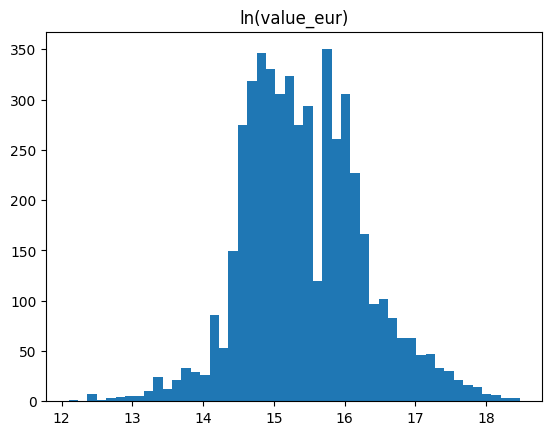

In [5]:
# Change scale of output variable
ylog = np.log(y)

plt.hist(ylog, bins='auto')
plt.title("ln(value_eur)")
plt.show()

In [6]:
X_train, X_test, ylog_train, ylog_test, y_train, y_test = train_test_split(X, ylog, y, test_size=0.25, random_state=42)

In [7]:
# Train XGBoost model, may take a few minutes
model = XGBRegressor(
    n_estimators=1000,       # más árboles, con tasa más baja
    learning_rate=0.02,      # más bajo → pasos más suaves
    max_depth=3,             # reduce complejidad de cada árbol
    subsample=0.7,           # más aleatoriedad (mejor generalización)
    colsample_bytree=0.7,    # usa menos features por árbol
    reg_alpha=0.3,           # L1 más fuerte
    reg_lambda=2.0,          # L2 más fuerte
    gamma=0.2,               # evita divisiones débiles
    min_child_weight=5,      # evita que el modelo se divida por ruido
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, ylog_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.2, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.02, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=5, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=-1, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

In [8]:
def predict_function(model, data):
    """Predict wrapper: original model was trained on log-output; return exp(pred) to recover original scale."""
    return np.exp(model.predict(data))

---
Ex 1. Ensure your model is not overfitted

In [9]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Predicciones en train y test
y_pred_train = np.exp(model.predict(X_train)) 
y_pred_test = np.exp(model.predict(X_test))

# Calcular errores
rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)

r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)

print(f"Train RMSE: {rmse_train:.2f} | Test RMSE: {rmse_test:.2f}")
print(f"Train R²: {r2_train:.3f} | Test R²: {r2_test:.3f}")


Train RMSE: 1883155.61 | Test RMSE: 2616827.46
Train R²: 0.955 | Test R²: 0.914


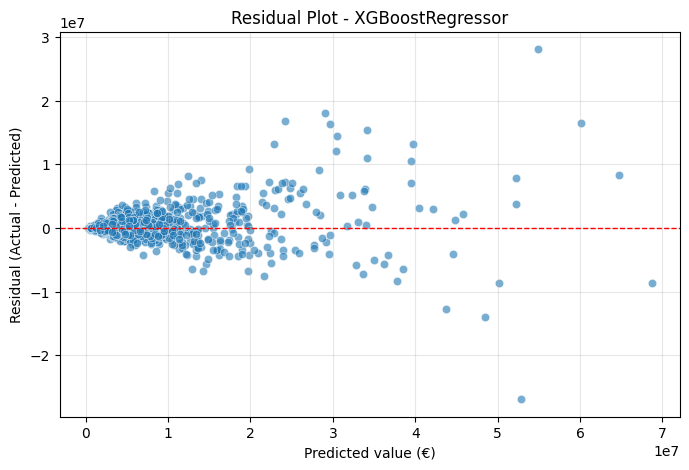

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Predicciones en test
y_pred = np.exp(model.predict(X_test))

# Cálculo de residuos
residuals = y_test - y_pred

# Plot
plt.figure(figsize=(8,5))
sns.scatterplot(x=y_pred, y=residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.xlabel("Predicted value (€)")
plt.ylabel("Residual (Actual - Predicted)")
plt.title("Residual Plot - XGBoostRegressor")
plt.grid(alpha=0.3)
plt.show()


El modelo generaliza bien, pero muestra ligero overfitting, ya que los errores aumentan en jugadores de mayor valor.

---
Ex 2. Obtain and plot variable importance measures using the following variable groups

In [11]:
variable_groups = {
    'age': ['age'],
    'body': ['height_cm', 'weight_kg'],
    'attacking': ['attacking_crossing', 'attacking_finishing', 'attacking_heading_accuracy', 'attacking_short_passing', 'attacking_volleys'],
    'skill': ['skill_dribbling', 'skill_curve', 'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control'],
    'movement': ['movement_acceleration', 'movement_sprint_speed', 'movement_agility', 'movement_reactions', 'movement_balance'],
    'power': ['power_shot_power', 'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots'],
    'mentality': ['mentality_aggression', 'mentality_interceptions', 'mentality_positioning', 'mentality_vision', 'mentality_penalties',
        'mentality_composure'],
    'defending': ['defending_marking', 'defending_standing_tackle','defending_sliding_tackle'],
    'goalkeeping' : ['goalkeeping_diving', 'goalkeeping_handling', 'goalkeeping_kicking', 'goalkeeping_positioning', 'goalkeeping_reflexes']
}

In [12]:
# Compute permutation importances
perm_imp = permutation_importance(model, X_test, y_test,
                           n_repeats=30,
                           random_state=0)

In [13]:
# Print the mean and standard deviation of permutation importances for each feature
import pandas as pd
import matplotlib.pyplot as plt

# Crear DataFrame con las importancias medias
feat_importances = pd.DataFrame({
    'feature': X_test.columns,
    'importance': perm_imp.importances_mean
})

# Sumar por grupos
group_importance = {}
for group, features in variable_groups.items():
    # Filtramos las features de ese grupo que están en X_test
    valid_feats = [f for f in features if f in feat_importances['feature'].values]
    group_importance[group] = feat_importances[feat_importances['feature'].isin(valid_feats)]['importance'].sum()

# Convertir a DataFrame ordenado
group_importance = pd.DataFrame.from_dict(group_importance, orient='index', columns=['importance'])
group_importance.sort_values('importance', ascending=False, inplace=True)


<Figure size 800x500 with 0 Axes>

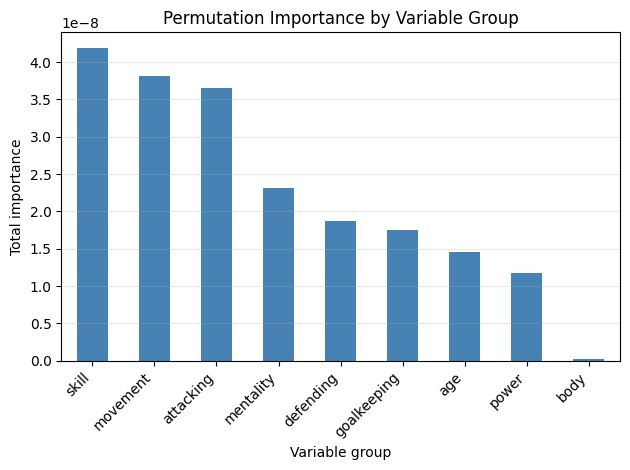

In [14]:
plt.figure(figsize=(8,5))
group_importance.plot(kind='bar', legend=False, color='steelblue')
plt.title("Permutation Importance by Variable Group")
plt.ylabel("Total importance")
plt.xlabel("Variable group")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

Podemos ver que la variable de mayor importancia es 'skill', lo cual tiene sentido dado el origen del dataset

---
Ex 3. Obtain which is the variable with higher influence in Leo Messi's value. Justify which algorithm you choose

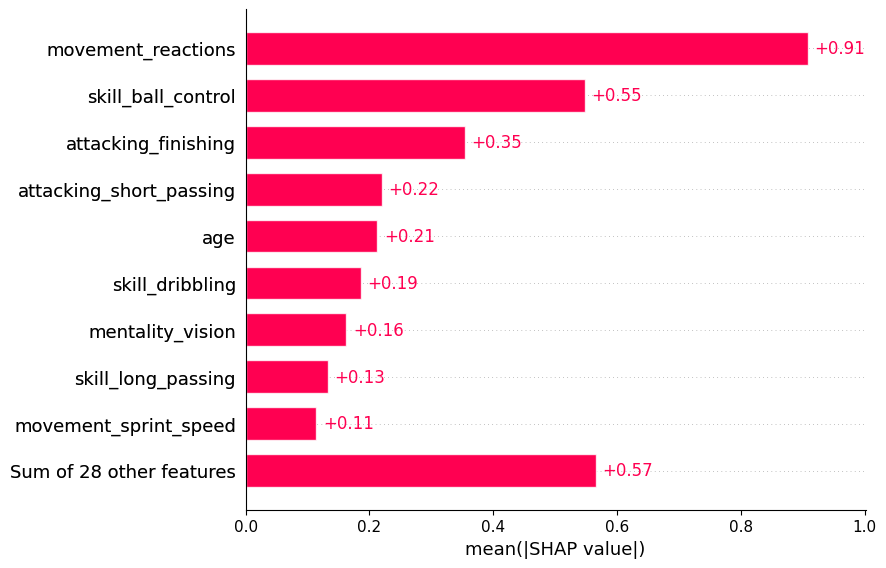

In [ ]:
# --- SHAP explanation (Messi) ---
import shap

# 1) Sample background data (para el explainer)
X100 = shap.utils.sample(X_train, 100, random_state=42)

# 2) Creo el explainer
explainer = shap.TreeExplainer(model, X100)

# 3) Calculo SHAP values en test
shap_values = explainer(X_test)

# 4) Busco fila de Messi
messi_row = df[df["short_name"] == "L. Messi"]
messi_X = messi_row[X.columns]

# 5) Obtengo valores SHAP de Messi
messi_shap = explainer(messi_X)

# 6) Visualización de contribución de cada variable
shap.plots.bar(messi_shap)



Se usa SHAP porque permite ver cuánto aporta cada variable a la predicción de un jugador concreto. A diferencia de otros métodos, SHAP muestra la influencia de cada característica en un caso individual, en este caso el de Leo Messi. La variable con el valor SHAP más alto en valor absoluto es la que más pesa en su valoración según el modelo, y en este caso es 'movement_reactions'

---
Ex 4. Explain how perturbating the `height_cm` variable affect the value of Cristiano Ronaldo

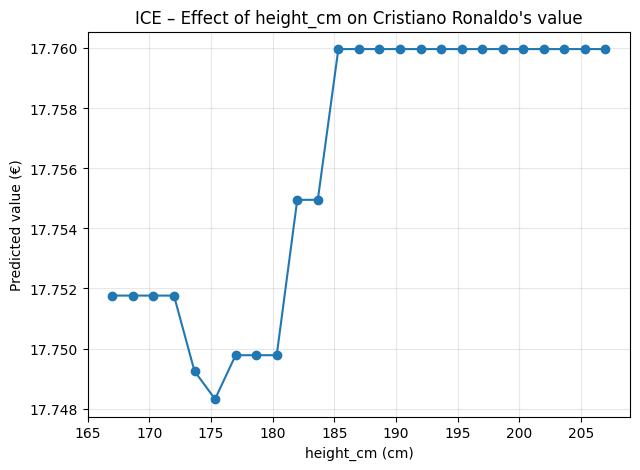

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- 1) Localiza a Cristiano y prepara la fila ---
cr_idx = df.loc[df['short_name'].str.contains('cristiano ronaldo', case=False)].index[0]
x0 = X.loc[cr_idx].copy()

feature = 'height_cm'                     # variable a perturbar
# rango (±10 cm alrededor de su altura real) o usa [X[feature].min(), X[feature].max()]
grid = np.linspace(x0[feature]-20, x0[feature]+20, 25)

# --- 2) Predicciones variando solo height_cm ---
preds = []
for v in grid:
    x_mod = x0.copy()
    x_mod[feature] = v
    x_mod_df = pd.DataFrame([x_mod], columns=X.columns)
    yhat = model.predict(x_mod_df)[0]
    preds.append(yhat)

# --- 3) Plot ICE ---
plt.figure(figsize=(7,5))
plt.plot(grid, preds, marker='o')
plt.xlabel('height_cm (cm)')
plt.ylabel('Predicted value (€)')
plt.title("ICE – Effect of height_cm on Cristiano Ronaldo's value")
plt.grid(alpha=0.3)
plt.show()


El modelo muestra que la altura influye poco en el valor de Cristiano Ronaldo. A partir de unos 181–185 cm hay un ligero aumento, tras el cual la predicción se mantiene constante. Esto refleja una relación no lineal

---
Ex 5. Explain the average effect of the `age` variable on the model predictions. Does it differ greatly along the samples in the dataset? Which should be more affected by perturbating this variable, the goalkeepers or the strikers?

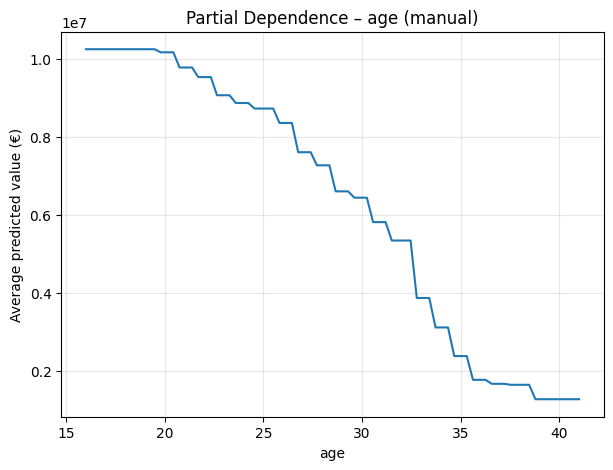

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

feature = 'age'
feature_values = np.linspace(X[feature].min(), X[feature].max(), num=80)

avg_preds = np.zeros_like(feature_values, dtype=float)
X_mod = X.copy()

for i, v in enumerate(feature_values):
    X_mod[feature] = v
    yhat = np.exp(model.predict(X_mod))   # modelo en log -> exponenciar
    avg_preds[i] = yhat.mean()

plt.figure(figsize=(7,5))
plt.plot(feature_values, avg_preds)
plt.xlabel('age')
plt.ylabel('Average predicted value (€)')
plt.title('Partial Dependence – age (manual)')
plt.grid(alpha=0.3)
plt.show()


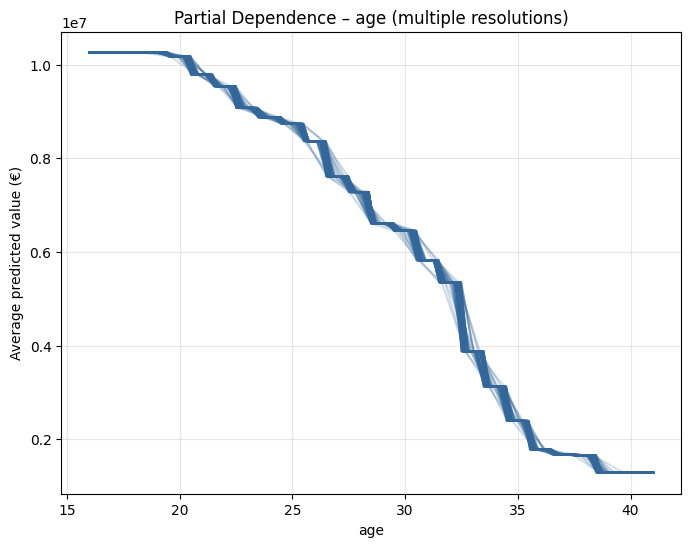

In [18]:
from matplotlib.colors import to_rgba

grid_length = np.linspace(20, 120, 40)   # nº de puntos por curva
base_color = (0.2, 0.4, 0.6)
min_alpha, max_alpha = 0.2, 1.0

fig, ax = plt.subplots(figsize=(8,6))
norm = (grid_length - grid_length.min()) / (grid_length.max() - grid_length.min())

for i, g in enumerate(grid_length):
    g = int(g)
    vals = np.linspace(X[feature].min(), X[feature].max(), num=g)
    X_mod = X.copy()
    avg = np.zeros_like(vals, dtype=float)
    for j, v in enumerate(vals):
        X_mod[feature] = v
        avg[j] = np.exp(model.predict(X_mod)).mean()
    color = to_rgba(base_color, min_alpha + (max_alpha - min_alpha) * norm[i])
    ax.plot(vals, avg, color=color)

ax.set_xlabel('age')
ax.set_ylabel('Average predicted value (€)')
ax.set_title('Partial Dependence – age (multiple resolutions)')
ax.grid(alpha=0.3)
plt.show()


El modelo muestra una relación negativa clara: a mayor edad, menor valor medio predicho, con una caída pronunciada a partir de los 28–30 años.
El efecto es consistente entre jugadores, por lo que no varía mucho entre muestras.

---
Ex 6. Explain the prediction made for Hazard using a local surrogate model (Lime)

In [21]:
import numpy as np
np.random.seed(42)

explainer = LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=X.columns,
    mode='regression',
    kernel_width=3,
    discretize_continuous=False
)

hazard_row = df[df["short_name"] == "E. Hazard"]
hazard_X = hazard_row[X.columns].values[0]

exp = explainer.explain_instance(
    hazard_X,
    model.predict,   # sin np.exp
    num_features=10
)

exp.show_in_notebook(show_table=True)


Las variables que más elevan el valor de Hazard son movement_reactions, skill_ball_control y attacking_short_passing, reflejando su técnica y rapidez. El modelo interpreta que estas habilidades son las que más impulsan su valoración.